In [1]:
import os
import numpy as np
from tqdm import tqdm
import random
import json
import pickle

from sklearn.model_selection import train_test_split
from params import PARAMS
from train import get_dataloaders

In [2]:
dataset = pickle.load(open('dataset/train/cross_subject_data_0_new.pickle', 'rb'))

In [3]:
random_seed = 0
X_train, X_test, y_train, y_test = dataset['X_train'], dataset['X_test'], dataset['y_train'], dataset['y_test'] 
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=PARAMS['VALID_SIZE'], shuffle=True, random_state=random_seed)
print('Data sizes:')
print('Train sizes:')
print(X_train.shape)
print(y_train.shape)
print('Valid sizes:')
print(X_valid.shape)
print(y_valid.shape)
print('Test sizes:')
print(X_test.shape)
print(y_test.shape)

dataloaders = get_dataloaders(X_train, y_train, X_valid, y_valid, X_test, y_test, PARAMS['BATCH_SIZE'], random_seed=random_seed, device=PARAMS['DEVICE'])

Data sizes:
Train sizes:
(7558, 64, 100)
(7558,)
Valid sizes:
(945, 64, 100)
(945,)
Test sizes:
(945, 64, 100)
(945,)


# GCRAM

In [19]:
from torch import nn
from layers import SelfAttentionLayer
from graph_utils import compute_adj_matrices
import torch.nn.functional as F

class GCRAM(nn.Module):
    def __init__(self, graph_type, seq_len, cnn_in_channels, cnn_n_kernels, cnn_kernel_size, cnn_stride, lstm_hidden_size, is_bidirectional, lstm_n_layers, attn_embed_dim, n_classes, lstm_dropout_p, dropout1_p, dropout2_p, device):
        super(GCRAM, self).__init__()

        self.dropout1_p = dropout1_p
        self.dropout2_p = dropout2_p

        self.conv1 = nn.Conv2d(cnn_in_channels, cnn_n_kernels, kernel_size=cnn_kernel_size, stride=cnn_stride)

        cnn_output_size = (seq_len - cnn_kernel_size[1])//cnn_stride + 1

        lstm_input_size = cnn_output_size * cnn_in_channels * cnn_n_kernels

        self.lstm1 = nn.LSTM(input_size=lstm_input_size, hidden_size=lstm_hidden_size, batch_first=True, bidirectional=is_bidirectional, num_layers=lstm_n_layers, dropout=lstm_dropout_p)

        if is_bidirectional:
            self.attention = SelfAttentionLayer(hidden_size=lstm_hidden_size*2, attention_size=attn_embed_dim, return_alphas=True)
        else:
            self.attention = SelfAttentionLayer(hidden_size=lstm_hidden_size, attention_size=attn_embed_dim, return_alphas=True)
        
        self.flatten = nn.Flatten()

        if is_bidirectional:
            self.linear = nn.Linear(lstm_hidden_size*2, n_classes)
        else:
            self.linear = nn.Linear(lstm_hidden_size, n_classes)

        self.adj = torch.from_numpy(compute_adj_matrices(graph_type)).to(device)

    def forward(self, x):
        out = torch.einsum("ij,kjl->kil", self.adj, x)
        
        out = out.unsqueeze(1)

        out = F.relu(self.conv1(out))

        out = self.flatten(out)
        out = out.unsqueeze(1)
        out = F.dropout(out, p=self.dropout1_p)

        out, (h_T, c_T) = self.lstm1(out)
        out = out[:, -1, :]

        out = out.unsqueeze(1)

        out, attn_weights = self.attention(out)
        out = F.dropout(out, p=self.dropout2_p)

        out = self.flatten(out)
        out = self.linear(out)

        return out

In [20]:
from main import init_model_params
import torch
from train import train_model_2

RANDOM_SEED = random_seed

SEQ_LEN = 100

model = GCRAM(graph_type='n', 
seq_len=SEQ_LEN, 
cnn_in_channels=PARAMS['GCRAM_CNN_IN_CHANNELS'], 
cnn_n_kernels=PARAMS['GCRAM_CNN_N_KERNELS'], 
cnn_kernel_size=PARAMS['GCRAM_CNN_KERNEL_SIZE'], 
cnn_stride=PARAMS['GCRAM_CNN_STRIDE'], 
lstm_hidden_size=PARAMS['GCRAM_LSTM_HIDDEN_SIZE'], 
is_bidirectional=PARAMS['GCRAM_LSTM_IS_BIDIRECTIONAL'], 
lstm_n_layers=PARAMS['GCRAM_LSTM_N_LAYERS'], 
attn_embed_dim=PARAMS['GCRAM_ATTN_EMBED_DIM'], 
n_classes=PARAMS['N_CLASSES'], 
lstm_dropout_p=PARAMS['GCRAM_LSTM_DROPOUT_P'], 
dropout1_p=PARAMS['GCRAM_DROPOUT1_P'], 
dropout2_p=PARAMS['GCRAM_DROPOUT2_P'], 
device=PARAMS['DEVICE'])

model = init_model_params(model, random_seed=RANDOM_SEED)
# model.init_node_embeddings()

model = model.to(PARAMS['DEVICE'])



2240


In [21]:
input = torch.FloatTensor(32, 64, SEQ_LEN)
input = input.to(PARAMS['DEVICE'])

out = model(input)

In [22]:
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(n_params)

1462316


In [23]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

N_EPOCHS = 100

# best_model, history = train_model(dataloaders, dataset_sizes, model, criterion, optimizer, scheduler, PARAMS['N_EPOCHS'], random_seed=random_seed)
best_model, history = train_model_2(model, optimizer, scheduler, criterion, dataloaders['train'], dataloaders['val'], N_EPOCHS, RANDOM_SEED, PARAMS['DEVICE'], verbose=True)
best_model = best_model.to(PARAMS['DEVICE'])

train() called: model=GCRAM, opt=Adam(lr=0.001000), epochs=100, device=cuda

Epoch   1/100, LR: 0.0010, train loss: 1.3380, train acc: 0.3490, val loss: 1.2314, val acc: 0.4300
Epoch  10/100, LR: 0.0010, train loss: 1.1681, train acc: 0.4951, val loss: 1.1422, val acc: 0.4881
Epoch  20/100, LR: 0.0009, train loss: 1.1478, train acc: 0.5072, val loss: 1.1355, val acc: 0.5140
Epoch  30/100, LR: 0.0008, train loss: 1.1272, train acc: 0.5207, val loss: 1.1054, val acc: 0.5237
Epoch  40/100, LR: 0.0007, train loss: 1.1224, train acc: 0.5245, val loss: 1.1081, val acc: 0.5119
Epoch  50/100, LR: 0.0007, train loss: 1.1000, train acc: 0.5399, val loss: 1.0752, val acc: 0.5485
Epoch  60/100, LR: 0.0006, train loss: 1.0872, train acc: 0.5437, val loss: 1.0721, val acc: 0.5442
Epoch  70/100, LR: 0.0005, train loss: 1.0860, train acc: 0.5442, val loss: 1.0820, val acc: 0.5356
Epoch  80/100, LR: 0.0005, train loss: 1.0737, train acc: 0.5467, val loss: 1.0641, val acc: 0.5291
Epoch  90/100, LR: 0.00

In [24]:
adj = best_model.adj.cpu().detach().numpy()

<AxesSubplot:>

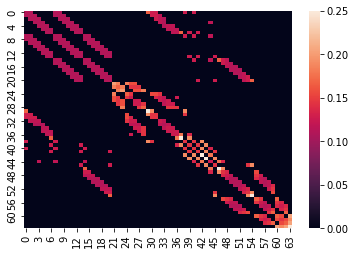

In [25]:
import seaborn as sns
sns.heatmap(adj)

In [26]:
from main import model_predict, print_classification_report

y_preds, y_test = model_predict(best_model, test_loader=dataloaders['test'])

cr, cm, auroc = print_classification_report(y_test, y_preds, PARAMS['N_CLASSES'])

In [27]:
print(cr)

{'0': {'precision': 0.6896551724137931, 'recall': 0.6086956521739131, 'f1-score': 0.6466512702078522, 'support': 230}, '1': {'precision': 0.6280193236714976, 'recall': 0.5508474576271186, 'f1-score': 0.5869074492099322, 'support': 236}, '2': {'precision': 0.45703125, 'recall': 0.5176991150442478, 'f1-score': 0.4854771784232365, 'support': 226}, '3': {'precision': 0.4961832061068702, 'recall': 0.5508474576271186, 'f1-score': 0.5220883534136546, 'support': 236}, 'accuracy': 0.5571120689655172, 'macro avg': {'precision': 0.5677222380480402, 'recall': 0.5570224206180995, 'f1-score': 0.5602810628136689, 'support': 928}, 'weighted avg': {'precision': 0.5681266693780896, 'recall': 0.5571120689655172, 'f1-score': 0.5605287110890345, 'support': 928}}


In [28]:
print(auroc)

0.704725372927907


<AxesSubplot:>

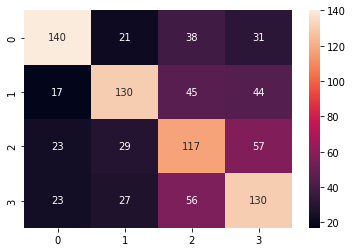

In [29]:
sns.heatmap(cm, annot=True, fmt='g')

# GCRAMAuto

In [136]:
from torch import nn
from layers import SelfAttentionLayer, BatchGraphConvolutionLayer
from graph_utils import compute_adj_matrices
import torch.nn.functional as F

class GCRAMAuto(nn.Module):
    def __init__(self, seq_len, n_nodes, gcn_hidden_size, cnn_in_channels, cnn_n_kernels, cnn_kernel_size, cnn_stride, lstm_hidden_size, is_bidirectional, lstm_n_layers, attn_embed_dim, n_classes, lstm_dropout_p, dropout1_p, dropout2_p, device):
        super(GCRAMAuto, self).__init__()

        self.dropout1_p = dropout1_p
        self.dropout2_p = dropout2_p

        self.gc1 = BatchGraphConvolutionLayer(seq_len, gcn_hidden_size, n_nodes)

        self.conv1 = nn.Conv2d(cnn_in_channels, cnn_n_kernels, kernel_size=cnn_kernel_size, stride=cnn_stride)

        cnn_output_size = (gcn_hidden_size - cnn_kernel_size[1])//cnn_stride + 1
        lstm_input_size = cnn_output_size * cnn_in_channels * cnn_n_kernels

        self.lstm1 = nn.LSTM(input_size=lstm_input_size, hidden_size=lstm_hidden_size, batch_first=True, bidirectional=is_bidirectional, num_layers=lstm_n_layers, dropout=lstm_dropout_p)

        if is_bidirectional:
            self.attention = SelfAttentionLayer(hidden_size=lstm_hidden_size*2, attention_size=attn_embed_dim, return_alphas=True)
        else:
            self.attention = SelfAttentionLayer(hidden_size=lstm_hidden_size, attention_size=attn_embed_dim, return_alphas=True)
        
        self.flatten = nn.Flatten()

        if is_bidirectional:
            self.linear = nn.Linear(lstm_hidden_size*2, n_classes)
        else:
            self.linear = nn.Linear(lstm_hidden_size, n_classes)

        self.adj = nn.Parameter(torch.randn(n_nodes, n_nodes), requires_grad=True)

    def forward(self, x):
        out = F.relu(self.gc1(x, self.adj))
        out = F.dropout(out, p=self.dropout1_p)
        
        out = out.unsqueeze(1)

        out = F.relu(self.conv1(out))
        out = self.flatten(out)
        out = out.unsqueeze(1)
        out = F.dropout(out, p=self.dropout1_p)

        out, (h_T, c_T) = self.lstm1(out)
        out = out[:, -1, :]

        out = out.unsqueeze(1)

        out, attn_weights = self.attention(out)
        out = F.dropout(out, p=self.dropout2_p)

        out = self.flatten(out)
        out = self.linear(out)

        return out

    def init_adj_diag(self):
        self.adj.data.fill_diagonal_(1)

In [137]:
from main import init_model_params
import torch
from train import train_model_2

RANDOM_SEED = random_seed

SEQ_LEN = 100

model = GCRAMAuto(seq_len=SEQ_LEN, 
n_nodes=64,
gcn_hidden_size=256,
cnn_in_channels=PARAMS['GCRAM_CNN_IN_CHANNELS'], 
cnn_n_kernels=PARAMS['GCRAM_CNN_N_KERNELS'], 
cnn_kernel_size=PARAMS['GCRAM_CNN_KERNEL_SIZE'], 
cnn_stride=10, 
lstm_hidden_size=PARAMS['GCRAM_LSTM_HIDDEN_SIZE'], 
is_bidirectional=PARAMS['GCRAM_LSTM_IS_BIDIRECTIONAL'], 
lstm_n_layers=PARAMS['GCRAM_LSTM_N_LAYERS'], 
attn_embed_dim=PARAMS['GCRAM_ATTN_EMBED_DIM'], 
n_classes=PARAMS['N_CLASSES'], 
lstm_dropout_p=PARAMS['GCRAM_LSTM_DROPOUT_P'], 
dropout1_p=PARAMS['GCRAM_DROPOUT1_P'], 
dropout2_p=PARAMS['GCRAM_DROPOUT2_P'], 
device=PARAMS['DEVICE'])

model = init_model_params(model, random_seed=RANDOM_SEED)
model.init_adj_diag()

model = model.to(PARAMS['DEVICE'])



In [138]:
input = torch.FloatTensor(32, 64, SEQ_LEN)
input = input.to(PARAMS['DEVICE'])

out = model(input)

In [139]:
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(n_params)

1226028


In [140]:
print(model)

GCNCRAMAuto(
  (gc1): BatchGraphConvolutionLayer (100 -> 256)
  (conv1): Conv2d(1, 40, kernel_size=(64, 45), stride=(5, 5))
  (lstm1): LSTM(1720, 64, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (attention): SelfAttentionLayer (128 -> 512)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=128, out_features=4, bias=True)
)


In [141]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

N_EPOCHS = 100

# best_model, history = train_model(dataloaders, dataset_sizes, model, criterion, optimizer, scheduler, PARAMS['N_EPOCHS'], random_seed=random_seed)
best_model, history = train_model_2(model, optimizer, scheduler, criterion, dataloaders['train'], dataloaders['val'], N_EPOCHS, RANDOM_SEED, PARAMS['DEVICE'], verbose=True)
best_model = best_model.to(PARAMS['DEVICE'])

train() called: model=GCNCRAMAuto, opt=Adam(lr=0.001000), epochs=100, device=cuda

Epoch   1/100, LR: 0.0010, train loss: 1.4133, train acc: 0.2655, val loss: 1.3460, val acc: 0.3276
Epoch  10/100, LR: 0.0010, train loss: 1.1770, train acc: 0.4552, val loss: 1.2054, val acc: 0.4300
Epoch  20/100, LR: 0.0009, train loss: 1.1727, train acc: 0.4597, val loss: 1.1631, val acc: 0.4644
Epoch  30/100, LR: 0.0008, train loss: 1.1557, train acc: 0.4792, val loss: 1.1674, val acc: 0.4450
Epoch  40/100, LR: 0.0007, train loss: 1.1669, train acc: 0.4747, val loss: 1.1588, val acc: 0.4892
Epoch  50/100, LR: 0.0007, train loss: 1.1440, train acc: 0.5019, val loss: 1.1100, val acc: 0.5086
Epoch  60/100, LR: 0.0006, train loss: 1.1385, train acc: 0.4995, val loss: 1.1313, val acc: 0.5075
Epoch  70/100, LR: 0.0005, train loss: 1.1529, train acc: 0.4831, val loss: 1.1413, val acc: 0.4601
Epoch  80/100, LR: 0.0005, train loss: 1.1359, train acc: 0.5120, val loss: 1.1400, val acc: 0.4978
Epoch  90/100, LR

In [142]:
adj = best_model.adj.cpu().detach().numpy()

<AxesSubplot:>

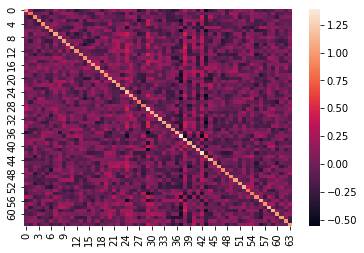

In [143]:
import seaborn as sns
sns.heatmap(adj)

In [144]:
from main import model_predict, print_classification_report

y_preds, y_test = model_predict(best_model, test_loader=dataloaders['test'])

cr, cm, auroc = print_classification_report(y_test, y_preds, PARAMS['N_CLASSES'])

In [145]:
print(cr)

{'0': {'precision': 0.75625, 'recall': 0.5260869565217391, 'f1-score': 0.6205128205128205, 'support': 230}, '1': {'precision': 0.6923076923076923, 'recall': 0.5338983050847458, 'f1-score': 0.6028708133971291, 'support': 236}, '2': {'precision': 0.4147058823529412, 'recall': 0.6238938053097345, 'f1-score': 0.4982332155477031, 'support': 226}, '3': {'precision': 0.491869918699187, 'recall': 0.5127118644067796, 'f1-score': 0.5020746887966805, 'support': 236}, 'accuracy': 0.5484913793103449, 'macro avg': {'precision': 0.5887833733399551, 'recall': 0.5491477328307497, 'f1-score': 0.5559228845635833, 'support': 928}, 'weighted avg': {'precision': 0.5895764500101166, 'recall': 0.5484913793103449, 'f1-score': 0.5561269331352033, 'support': 928}}


In [146]:
print(auroc)

0.6994600660880206


<AxesSubplot:>

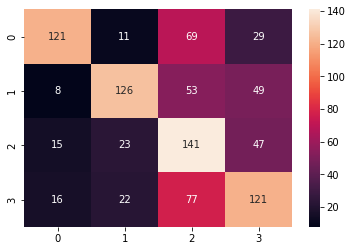

In [147]:
sns.heatmap(cm, annot=True, fmt='g')